In [1]:
import codigo
from codigo import utils
from codigo import model_LSTM
from codigo import model_utils
from cg_ega.cg_ega import CG_EGA

In [2]:
import pandas as pd
import numpy as np
pd.set_option('mode.chained_assignment',None)
import matplotlib.pyplot as plt
import seaborn as sns
import math

%matplotlib inline

In [3]:
import tensorflow as tf
from tensorflow import keras

In [4]:
modeloBasePath='modelos/modeloGeneral/bidirectional_dropout.h5'
modeloSave='/transfer_bidirectional_dropout_balanceado.h5'

In [5]:
balanceo='_down_equals'

In [6]:
from pickle import load
scalerGlucosa = load(open('dataset/generado/scalerGlucosa.scaler', 'rb'))

In [7]:
paciente='paciente4'

In [8]:
with open('dataset/generado/'+paciente+'/array_Xtrain'+balanceo+'.npy', 'rb') as f:
    array_Xtrain = np.load(f)

In [9]:
len(array_Xtrain)

8346

In [10]:
with open('dataset/generado/'+paciente+'/array_Ytrain'+balanceo+'.npy', 'rb') as f:
    array_Ytrain = np.load(f)

In [11]:
len(array_Ytrain)

8346

In [12]:
with open('dataset/generado/'+paciente+'/array_Xval'+balanceo+'.npy', 'rb') as f:
    array_Xval = np.load(f)

In [13]:
len(array_Xval)

990

In [14]:
with open('dataset/generado/'+paciente+'/array_Yval'+balanceo+'.npy', 'rb') as f:
    array_Yval = np.load(f)

In [15]:
len(array_Yval)

990

In [16]:
with open('dataset/generado/'+paciente+'/array_Xtest.npy', 'rb') as f:
    array_Xtest = np.load(f)

In [17]:
len(array_Xtest)

6201

In [18]:
with open('dataset/generado/'+paciente+'/array_Ytest.npy', 'rb') as f:
    array_Ytest = np.load(f)

In [19]:
len(array_Ytest)

6201

In [20]:
epochs = 100
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_mae', mode='min', patience=3, min_delta=0.001)

# Rendimiento del Modelo base

In [21]:
base_model = keras.models.load_model(modeloBasePath)

194/194 [==============================] - 2s 8ms/step


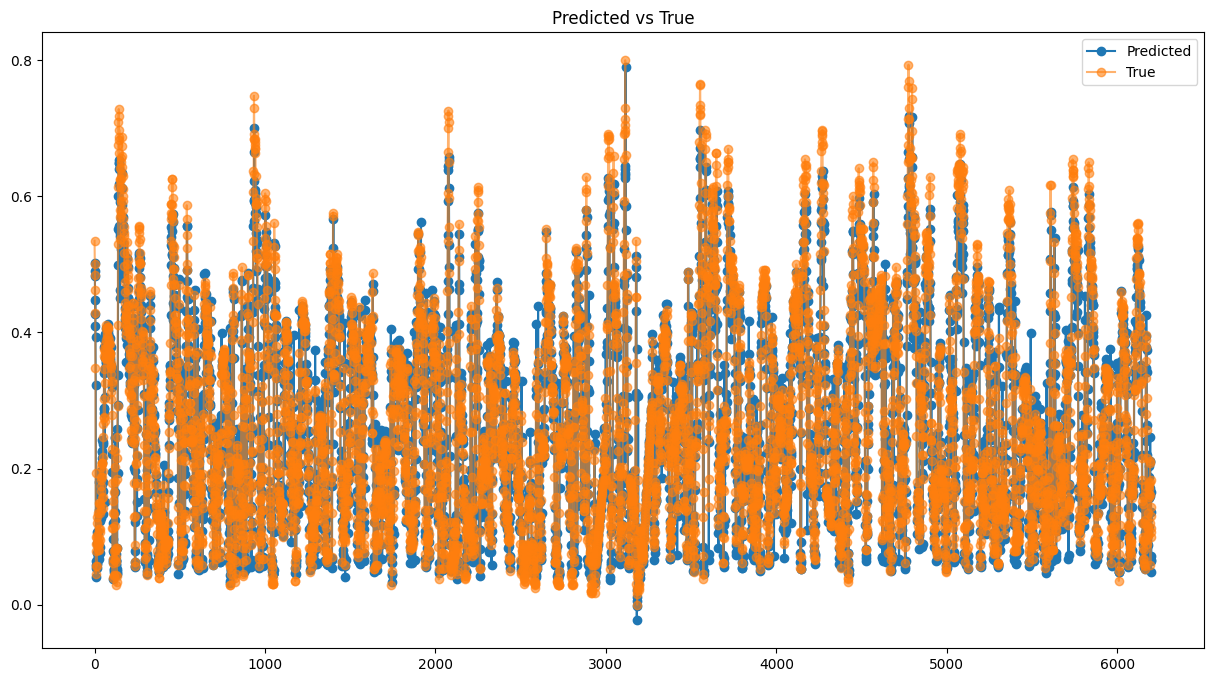

In [22]:
yhat = base_model.predict(array_Xtest)
model_utils.plotPredicted(yhat,array_Ytest)

In [23]:
model_utils.forecast_accuracy(yhat,array_Ytest)

{'mae': 0.04000771300020579,
 'mse': 0.05623624111014498,
 'rmse': 0.0031625148141983606}

# Iniciamos transfer learning

In [24]:
base_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 64)               9728      
 l)                                                              
                                                                 
 dropout_6 (Dropout)         (None, 64)                0         
                                                                 
 dense_12 (Dense)            (None, 64)                4160      
                                                                 
 dropout_7 (Dropout)         (None, 64)                0         
                                                                 
 dense_13 (Dense)            (None, 32)                2080      
                                                                 
 dropout_8 (Dropout)         (None, 32)                0         
                                                      

In [25]:
base_model.layers[-2].output

<KerasTensor: shape=(None, 32) dtype=float32 (created by layer 'dropout_8')>

In [26]:
transferModel=model_LSTM.transferLearning_NewModel(base_model,-3,False,True)
transferModel.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_input (InputL  [(None, 30, 5)]          0         
 ayer)                                                           
                                                                 
 bidirectional (Bidirectiona  (None, 64)               9728      
 l)                                                              
                                                                 
 dropout_6 (Dropout)         (None, 64)                0         
                                                                 
 dense_12 (Dense)            (None, 64)                4160      
                                                                 
 dropout_7 (Dropout)         (None, 64)                0         
                                                                 
 dense_13 (Dense)            (None, 32)                2080  

In [27]:
array_Xtrain.shape

(8346, 30, 5)

In [28]:
transferModel.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse', metrics=['mae','mse'])

history =transferModel.fit(array_Xtrain, array_Ytrain,epochs=epochs, validation_data=(array_Xval, array_Yval), shuffle=False, callbacks=[early_stopping])
transferModel.save('modelos/'+paciente+modeloSave)

Epoch 1/100
261/261 [==============================] - 9s 19ms/step - loss: 0.0030 - mae: 0.0363 - mse: 0.0030 - val_loss: 0.0025 - val_mae: 0.0353 - val_mse: 0.0025
Epoch 2/100
261/261 [==============================] - 4s 15ms/step - loss: 0.0018 - mae: 0.0293 - mse: 0.0018 - val_loss: 0.0025 - val_mae: 0.0350 - val_mse: 0.0025
Epoch 3/100
261/261 [==============================] - 3s 12ms/step - loss: 0.0018 - mae: 0.0290 - mse: 0.0018 - val_loss: 0.0023 - val_mae: 0.0335 - val_mse: 0.0023
Epoch 4/100
261/261 [==============================] - 3s 12ms/step - loss: 0.0017 - mae: 0.0290 - mse: 0.0017 - val_loss: 0.0024 - val_mae: 0.0340 - val_mse: 0.0024
Epoch 5/100
261/261 [==============================] - 4s 14ms/step - loss: 0.0017 - mae: 0.0289 - mse: 0.0017 - val_loss: 0.0022 - val_mae: 0.0329 - val_mse: 0.0022
Epoch 6/100
261/261 [==============================] - 4s 15ms/step - loss: 0.0017 - mae: 0.0289 - mse: 0.0017 - val_loss: 0.0021 - val_mae: 0.0324 - val_mse: 0.0021
Epoc

194/194 [==============================] - 2s 10ms/step - loss: 0.0037 - mae: 0.0439 - mse: 0.0037
test loss, test acc: [0.0036519335117191076, 0.04394548386335373, 0.0036519335117191076]


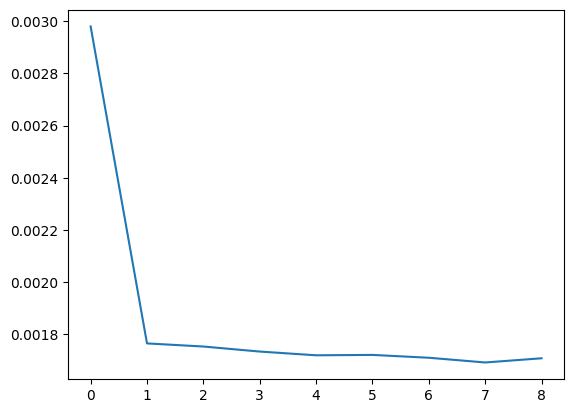

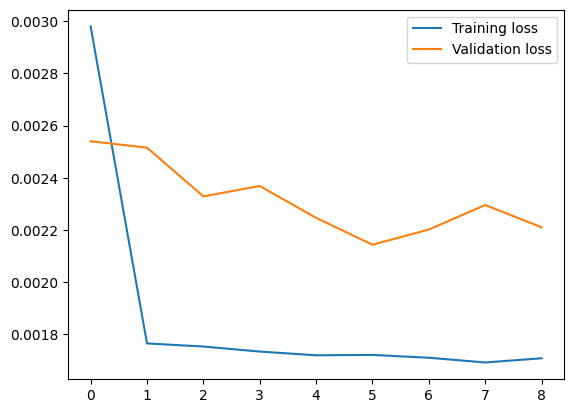

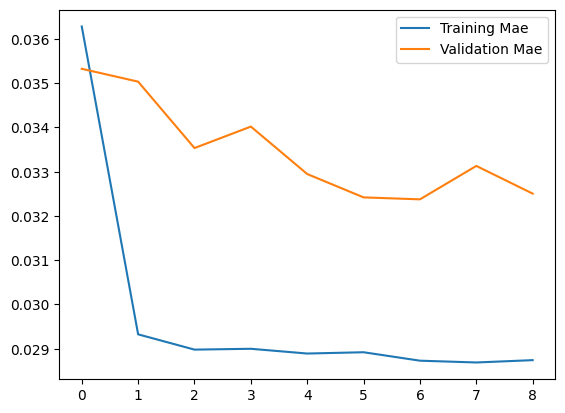

In [29]:
model_utils.modelEvaluateTraining(transferModel,history,array_Xtest, array_Ytest)

194/194 [==============================] - 2s 9ms/step


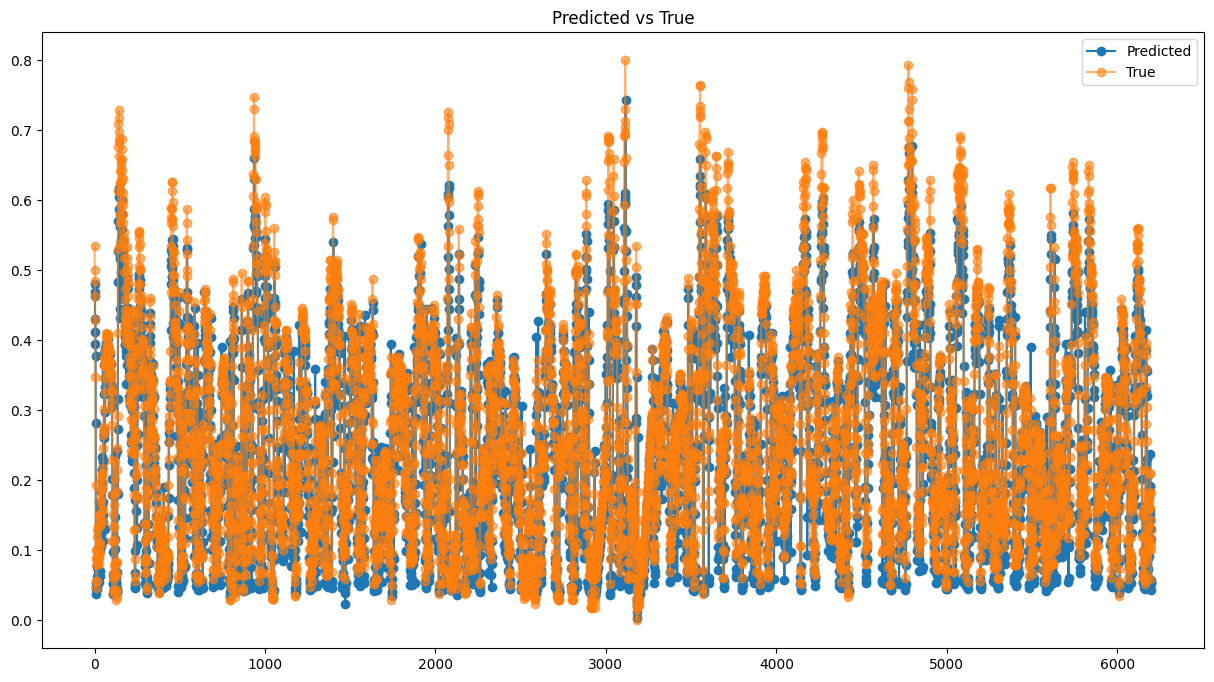

In [30]:
yhat = transferModel.predict(array_Xtest)
model_utils.plotPredicted(yhat,array_Ytest)

In [31]:
model_utils.forecast_accuracy(yhat,array_Ytest)

{'mae': 0.043945483168709214,
 'mse': 0.06043123817042712,
 'rmse': 0.003651934546810888}

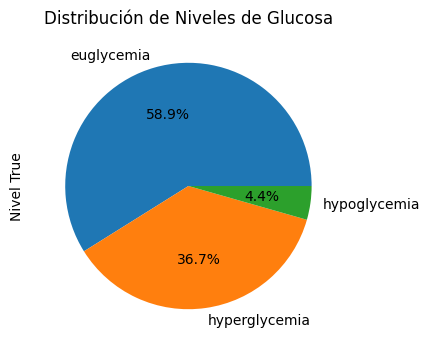

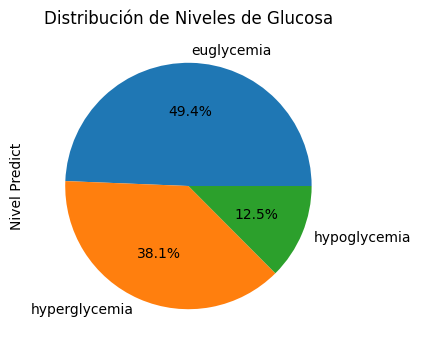

,Glucose level True,Nivel True,Glucose level Predict,Nivel Predict
0,286.0,hyperglycemia,255.816345,hyperglycemia
1,270.0,hyperglycemia,260.694031,hyperglycemia
2,263.0,hyperglycemia,252.920609,hyperglycemia
3,253.0,hyperglycemia,229.244080,hyperglycemia
4,237.0,hyperglycemia,237.809998,hyperglycemia


In [32]:
Y_scaled=scalerGlucosa.inverse_transform(array_Ytest)
yhat_scaled=scalerGlucosa.inverse_transform(yhat)

df_glucose = pd.DataFrame(Y_scaled, columns=['Glucose level True']) 
df_glucose['Nivel True'] = df_glucose['Glucose level True'].apply(utils.label_LevelBG) 
df_glucose['Nivel True'].value_counts().plot.pie(title='Distribución de Niveles de Glucosa',y='level_label',legend=False,autopct='%1.1f%%',figsize=(10, 4))
plt.show()

df_glucose['Glucose level Predict']=yhat_scaled
df_glucose['Nivel Predict'] = df_glucose['Glucose level Predict'].apply(utils.label_LevelBG) 

df_glucose['Nivel Predict'].value_counts().plot.pie(title='Distribución de Niveles de Glucosa',y='level_label',legend=False,autopct='%1.1f%%',figsize=(10, 4))
plt.show()

df_glucose.head()


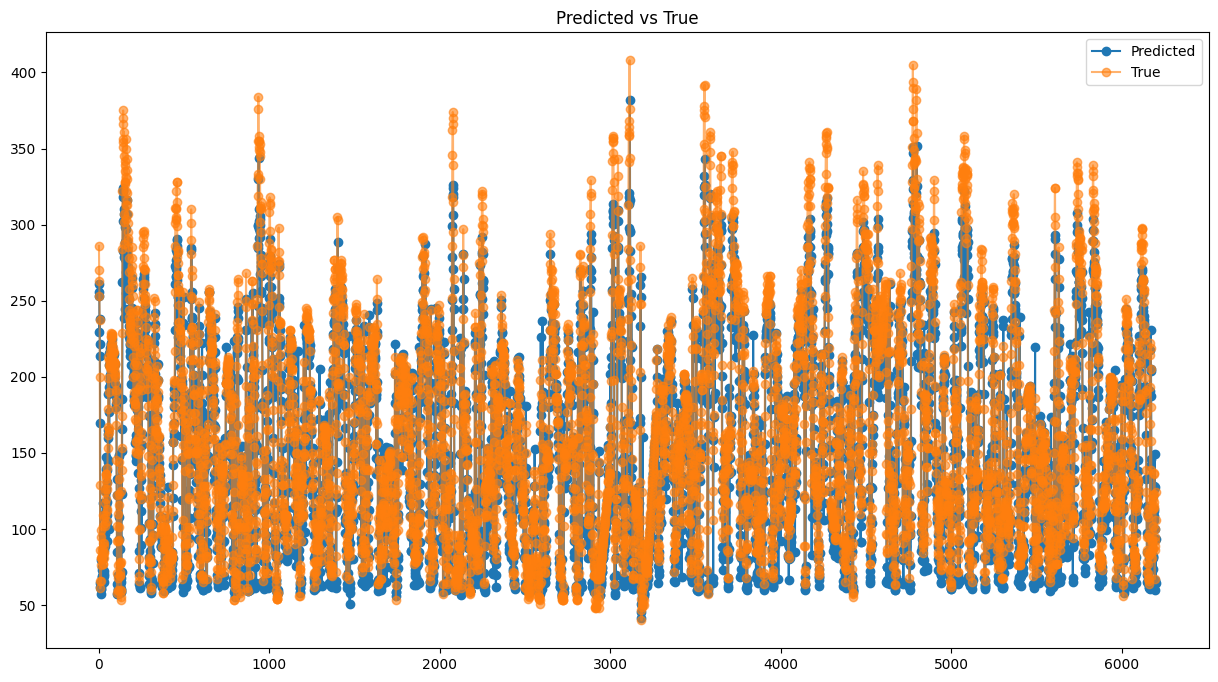

{'mae': 20.214922754931585, 'mse': 27.79837026727006, 'rmse': 772.749389516244}

In [33]:
model_utils.plotPredicted(yhat_scaled,Y_scaled)
model_utils.forecast_accuracy(yhat_scaled,Y_scaled)

In [34]:
dfPlot=pd.DataFrame()
dfPlot['y_true']=df_glucose['Glucose level True']
dfPlot['y_pred']=df_glucose['Glucose level Predict']
dfPlot.index=pd.date_range("2023-01-01", periods=len(df_glucose['Glucose level True']), freq="15min")
dfPlot

,y_true,y_pred
2023-01-01 00:00:00,286.0,255.816345
2023-01-01 00:15:00,270.0,260.694031
2023-01-01 00:30:00,263.0,252.920609
2023-01-01 00:45:00,253.0,229.244080
2023-01-01 01:00:00,237.0,237.809998
...,...,...
2023-03-06 13:00:00,100.0,59.755814
2023-03-06 13:15:00,89.0,99.842926
2023-03-06 13:30:00,92.0,66.773911
2023-03-06 13:45:00,106.0,64.337769


AP, BE, EP: (0.8529032258064516, 0.10870967741935483, 0.038387096774193545)


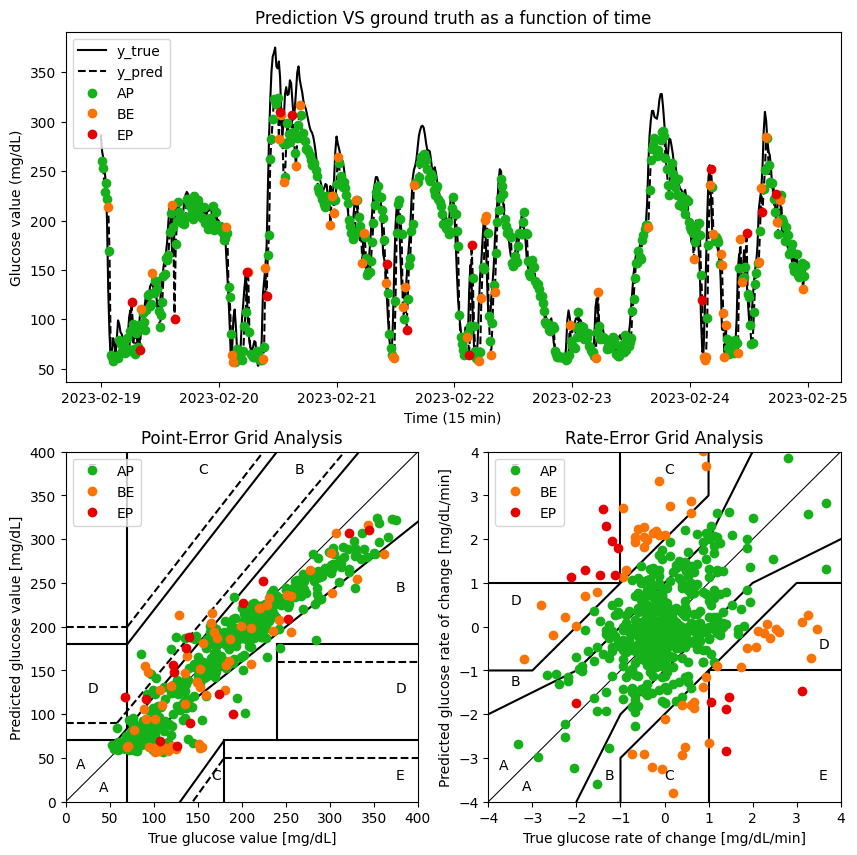

In [35]:
freq = 15
cg_ega = CG_EGA(dfPlot, freq)
print("AP, BE, EP:", cg_ega.reduced())
cg_ega.plot(day=5)